c:\Users\samra\anaconda3\envs\offence\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 1174/1174 [04:35<00:00,  4.26it/s]


Epoch 1/15, Loss: 0.1803


100%|██████████| 1174/1174 [04:42<00:00,  4.15it/s]


Epoch 2/15, Loss: 0.1211


100%|██████████| 1174/1174 [04:41<00:00,  4.17it/s]


Epoch 3/15, Loss: 0.0872


100%|██████████| 1174/1174 [04:37<00:00,  4.24it/s]


Epoch 4/15, Loss: 0.0576


100%|██████████| 1174/1174 [04:43<00:00,  4.14it/s]


Epoch 5/15, Loss: 0.0340


100%|██████████| 1174/1174 [04:38<00:00,  4.22it/s]


Epoch 6/15, Loss: 0.0263


100%|██████████| 1174/1174 [04:40<00:00,  4.18it/s]


Epoch 7/15, Loss: 0.0163


100%|██████████| 1174/1174 [04:43<00:00,  4.14it/s]


Epoch 8/15, Loss: 0.0134


100%|██████████| 1174/1174 [04:49<00:00,  4.06it/s]


Epoch 9/15, Loss: 0.0081


100%|██████████| 1174/1174 [04:39<00:00,  4.20it/s]


Epoch 10/15, Loss: 0.0075


100%|██████████| 1174/1174 [04:37<00:00,  4.22it/s]


Epoch 11/15, Loss: 0.0060


100%|██████████| 1174/1174 [04:39<00:00,  4.20it/s]


Epoch 12/15, Loss: 0.0066


100%|██████████| 1174/1174 [04:36<00:00,  4.25it/s]


Epoch 13/15, Loss: 0.0043


100%|██████████| 1174/1174 [04:36<00:00,  4.25it/s]


Epoch 14/15, Loss: 0.0032


100%|██████████| 1174/1174 [04:39<00:00,  4.21it/s]


Epoch 15/15, Loss: 0.0032

Validation Metrics:
Accuracy: 0.9484558040468584
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4264
         1.0       0.74      0.68      0.71       431

    accuracy                           0.95      4695
   macro avg       0.85      0.83      0.84      4695
weighted avg       0.95      0.95      0.95      4695

AUC: 0.9410270739107534


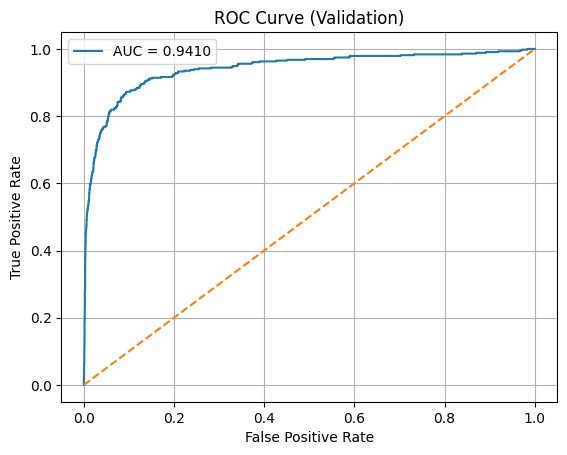

KeyError: "['toxic'] not in index"

In [1]:
# model2_implementation.ipynb

# ================================
# Offensive Language Classification - Model 2 (Transformer)
# Multilingual BERT Fine-Tuning (toxic label only)
# ================================

# Imports
import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import  get_scheduler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# ================================
# Preprocessing Function
# ================================
stop_words_en = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#','', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_en]
    return " ".join(tokens)

# ================================
# Load and preprocess data
# ================================
train_df = pd.read_csv("../offence_data/train.csv") 
test_df = pd.read_csv("../offence_data/validation.csv") 

train_df['feedback_text'] = train_df['feedback_text'].apply(preprocess)
test_df['feedback_text'] = test_df['feedback_text'].apply(preprocess)

# Only using 'toxic' label
train_df = train_df[['feedback_text', 'toxic']]
test_df = test_df[['id', 'feedback_text']]

# ================================
# Tokenization and Dataset
# ================================
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

class ToxicDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Split dataset
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['feedback_text'].tolist(),
    train_df['toxic'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = ToxicDataset(train_texts, train_labels)
val_dataset = ToxicDataset(val_texts, val_labels)

test_dataset = ToxicDataset(test_df['feedback_text'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# ================================
# Model
# ================================
class ToxicClassifier(nn.Module):
    def __init__(self):
        super(ToxicClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return torch.sigmoid(self.fc(output))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToxicClassifier().to(device)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 15
total_steps = len(train_loader) * epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.BCELoss()

# ================================
# Training
# ================================
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask).squeeze()
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# ================================
# Evaluation on validation set
# ================================
model.eval()
preds, trues = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids, attention_mask).squeeze().cpu().numpy()
        preds.extend(outputs)
        trues.extend(labels)

# Binarize predictions
bin_preds = [1 if p >= 0.5 else 0 for p in preds]

print("\nValidation Metrics:")
print("Accuracy:", accuracy_score(trues, bin_preds))
print(classification_report(trues, bin_preds))
print("AUC:", roc_auc_score(trues, preds))

# Plot AUC-ROC
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation)')
plt.legend()
plt.grid()
plt.show()

# ================================
# Test Predictions + Evaluation
# ================================
model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask).squeeze().cpu().numpy()
        test_preds.extend(outputs)

final_preds = [1 if p >= 0.5 else 0 for p in test_preds]


# Save submission
submission = test_df[['id', 'toxic']]
submission.to_csv("bert_predictions.csv", index=False)

print("\n✅ Multilingual BERT model completed. Predictions saved as 'bert_predictions.csv'")

# Optional: If true test labels exist, calculate metrics
if 'toxic' in test_df.columns:
    print("\nTest Set Metrics:")
    print("Accuracy:", accuracy_score(test_df['toxic'], final_preds))
    print(classification_report(test_df['toxic'], final_preds))
    print("AUC:", roc_auc_score(test_df['toxic'], test_preds))

    fpr, tpr, _ = roc_curve(test_df['toxic'], test_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend()
    plt.grid()
    plt.show()


In [2]:
test_df = pd.read_csv("../offence_data/validation.csv") 
print("Accuracy:", accuracy_score(test_df['toxic'], final_preds))

Accuracy: 0.8488095238095238


In [5]:
import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import  get_scheduler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
final_preds

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [ ]:
# model2_multilabel_toxic_only_prediction.py

# ====================
# Imports
# ====================
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_scheduler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# NLTK setup
nltk.download('stopwords')
nltk.download('wordnet')

# ====================
# Preprocessing
# ====================
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# ====================
# Load Data
# ====================
train_df = pd.read_csv("../offence_data/train.csv")
val_df = pd.read_csv("../offence_data/validation.csv")
test_df = pd.read_csv("../offence_data/test.csv")

# Apply preprocessing
train_df['feedback_text'] = train_df['feedback_text'].apply(preprocess)
val_df['feedback_text'] = val_df['feedback_text'].apply(preprocess)
test_df['feedback_text'] = test_df['content'].apply(preprocess)

# Label columns
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

# ====================
# Tokenization and Dataset
# ====================
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

class ToxicDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset = ToxicDataset(train_df['feedback_text'].tolist(), train_df[label_cols].values.tolist())
val_dataset = ToxicDataset(val_df['feedback_text'].tolist(), val_df[['toxic']].values.tolist())
test_dataset = ToxicDataset(test_df['feedback_text'].tolist(), labels=None)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# ====================
# Model
# ====================
class ToxicClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 6)  # 6 labels

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output.pooler_output)
        return torch.sigmoid(self.fc(pooled_output))

# ====================
# Training Setup
# ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToxicClassifier().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
loss_fn = nn.BCELoss()
total_steps = len(train_loader) * epochs
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# ====================
# Training Loop
# ====================
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# ====================
# Validation Evaluation (TOXIC only)
# ====================
model.eval()
val_preds, val_trues = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(input_ids, attention_mask).cpu().numpy()

        val_preds.extend(outputs[:, 0])  # Only TOXIC
        val_trues.extend(labels[:, 0])  # Only TOXIC

val_preds = np.array(val_preds)
val_trues = np.array(val_trues)
val_bin_preds = (val_preds >= 0.5).astype(int)

print("\n Validation Classification Report (TOXIC only):")
print(classification_report(val_trues, val_bin_preds))
print("AUC:", roc_auc_score(val_trues, val_preds))

# ROC curve for TOXIC
fpr, tpr, _ = roc_curve(val_trues, val_preds)
plt.figure()
plt.plot(fpr, tpr, label="TOXIC AUC = %0.4f" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TOXIC - Validation)')
plt.legend()
plt.grid()
plt.show()

# ====================
# Test Prediction (TOXIC Only)
# ====================
toxic_preds = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask).cpu().numpy()
        toxic_preds.extend(outputs[:, 0])  # Only TOXIC

final_preds = (np.array(toxic_preds) >= 0.5).astype(int)

# ====================
# Save Predictions
# ====================
submission = test_df[['id']].copy()
submission['toxic'] = final_preds
submission.to_csv("bert_toxic_predictions.csv", index=False)

print("\n✅ Finished. Test predictions saved to 'bert_toxic_predictions.csv'")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Epoch 1: 100%|██████████| 1468/1468 [05:46<00:00,  4.23it/s]


Epoch 1 Loss: 0.0800


Epoch 2: 100%|██████████| 1468/1468 [05:47<00:00,  4.23it/s]


Epoch 2 Loss: 0.0530


Epoch 3:  95%|█████████▍| 1388/1468 [05:31<00:19,  4.16it/s]


 Validation Classification Report (TOXIC only):
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       706
         1.0       0.50      0.03      0.06       134

    accuracy                           0.84       840
   macro avg       0.67      0.51      0.48       840
weighted avg       0.79      0.84      0.78       840

AUC: 0.7858547207306246


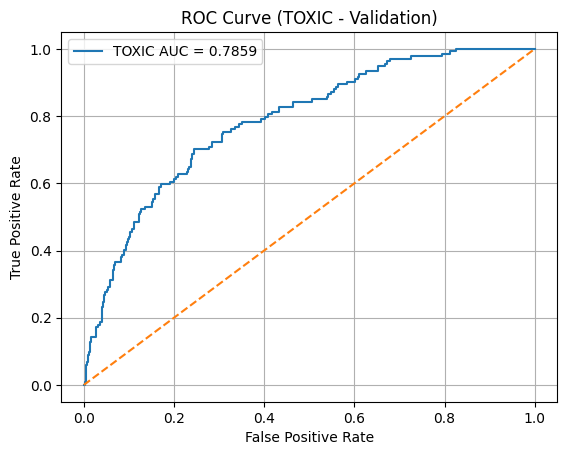

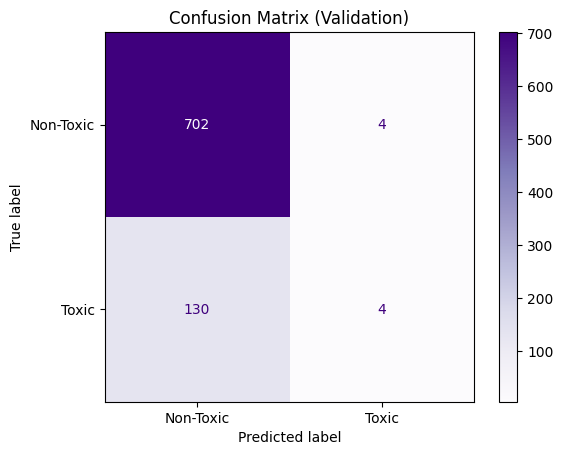

In [ ]:
# Validation Evaluation (TOXIC only)

model.eval()
val_preds, val_trues = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(input_ids, attention_mask).cpu().numpy()

        val_preds.extend(outputs[:, 0])  # Only TOXIC
        val_trues.extend(labels[:, 0])  # Only TOXIC

val_preds = np.array(val_preds)
val_trues = np.array(val_trues)
val_bin_preds = (val_preds >= 0.5).astype(int)

print("\n Validation Classification Report (TOXIC only):")
print(classification_report(val_trues, val_bin_preds))
print("AUC:", roc_auc_score(val_trues, val_preds))

# ROC Curve (Validation)
fpr, tpr, _ = roc_curve(val_trues, val_preds)
plt.figure()
plt.plot(fpr, tpr, label="TOXIC AUC = %0.4f" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TOXIC - Validation)')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix (Validation)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_val = confusion_matrix(val_trues, val_bin_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Non-Toxic', 'Toxic'])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix (Validation)")
plt.grid(False)
plt.show()


In [ ]:
# Test Evaluation (TOXIC Only)

if 'toxic' in test_df.columns:
    test_trues = test_df['toxic'].values
    test_preds = np.array(toxic_preds)
    test_bin_preds = (test_preds >= 0.5).astype(int)

    print("\n Test Classification Report (TOXIC only):")
    print(classification_report(test_trues, test_bin_preds))
    print("AUC:", roc_auc_score(test_trues, test_preds))

    # ROC curve for TOXIC (test)
    fpr_test, tpr_test, _ = roc_curve(test_trues, test_preds)
    plt.figure()
    plt.plot(fpr_test, tpr_test, label="TOXIC AUC = %0.4f" % auc(fpr_test, tpr_test))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (TOXIC - Test)')
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix (test)
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm_test = confusion_matrix(test_trues, test_bin_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Non-Toxic', 'Toxic'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Test)")
    plt.grid(False)
    plt.show()
else:
    print("\n⚠️ Skipping test evaluation – 'toxic' column not found in test_df.")



⚠️ Skipping test evaluation – 'toxic' column not found in test_df.
